# Trabalho Prático 3 - Regressão
<p>
<b>Aplicação: Predição</b><br>
<b>Método: Ajuste de Curvas – Regressão Linear e Polinomial</b><br>
<b>Objetivo: Implementar um Jupyter Notebook para fazer modelos de regressão para prever a taxa de mortalidade infantil de diversos países.</b><br>
</p>

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas.tools.plotting import parallel_coordinates
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from scipy.linalg import cho_factor, cho_solve
from IPython.display import Markdown
import warnings
warnings.filterwarnings("ignore")


<h1>Mortalidade infantil</h1>
<p>A taxa de mortalidade infantil é obtida por meio do número de crianças de um determinado local (cidade, região, país, continente) que morrem antes de completar 1 ano, a cada mil nascidas vivas. </p>
<p>Dados como  sistema de saúde, produto interno bruto, educação, industria, entre outros, são fundamentais para obter informações sobre este problema. Dessa forma, o objetivo deste trabalho é descobrir quais os melhores dados para serem usados numa regressão da taxa de mortalidade infantil.</p>

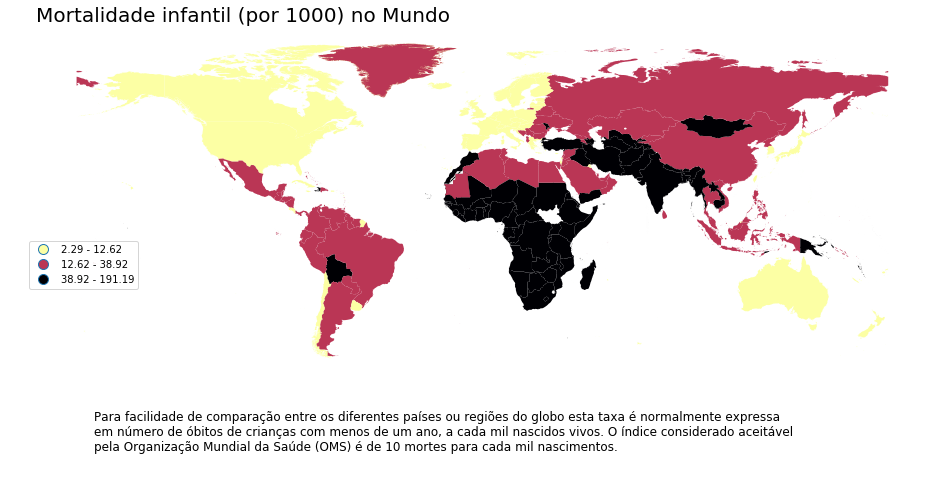

In [12]:
colors = 3
cmap = 'inferno_r'
figsize = (16, 10)
column = 'Infant_mortality'
cols = ['Country', 'Code',column]
title = 'Mortalidade infantil (por 1000) no Mundo'
description = '''
Para facilidade de comparação entre os diferentes países ou regiões do globo esta taxa é normalmente expressa 
em número de óbitos de crianças com menos de um ano, a cada mil nascidos vivos. O índice considerado aceitável
pela Organização Mundial da Saúde (OMS) é de 10 mortes para cada mil nascimentos.'''.strip()

shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

dictGeo = {
    'ADM0_A3':[],
    'geometry':[]
}
for country in countries:
    dictGeo['ADM0_A3'].append(country.attributes['ADM0_A3'])
    dictGeo['geometry'].append(country.geometry)

geo = gpd.GeoDataFrame(dictGeo)
cw = pd.read_csv('countries of the world.csv',usecols=cols)
merged = geo.merge(cw, left_on='ADM0_A3', right_on='Code')

ax = merged.dropna().plot(column=column, cmap=cmap, figsize=figsize, scheme='quantiles', k=colors, legend=True)
merged[merged.isna().any(axis=1)].plot(ax=ax, color='#fafafa', hatch='///')
ax.set_title(title, fontdict={'fontsize': 20}, loc='left')
ax.annotate(description, xy=(0.1, 0.1), size=12, xycoords='figure fraction')
ax.set_axis_off()
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.get_figure()
plt.show()


<h1>Base de Dados</h1>
<h3>Countries of the World</h3>
<b>Nomes de países ligados à região, população, tamanho da área, PIB, mortalidade e mais</b>
<p>Fonte: Todos esses conjuntos de dados são compostos de dados do governo dos EUA. Os dados do World Factbook podem ser usados livremente por qualquer pessoa a qualquer momento sem pedir permissão".
https://www.cia.gov/library/publications/the-world-factbook/docs/faqs.html</p>

In [13]:
cw = pd.read_csv('countries of the world.csv')
cw.head()

,Code,Country,Region,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP,...,Phones,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,AFG,Afghanistan,ASIA,31056997,647500,48.0,0.00,23.06,163.07,700.0,...,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.38,0.24,0.38
1,ALB,Albania,EASTERN_EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,...,71.2,21.09,4.42,74.49,3.0,15.11,5.22,232.00,188.00,579.00
2,DZA,Algeria,NORTHERN_AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,...,78.1,3.22,0.25,96.53,1.0,17.14,4.61,101.00,0.60,298.00
3,ASM,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,...,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,AND,Andorra,WESTERN_EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,...,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


<h1>Plot da base</h1>

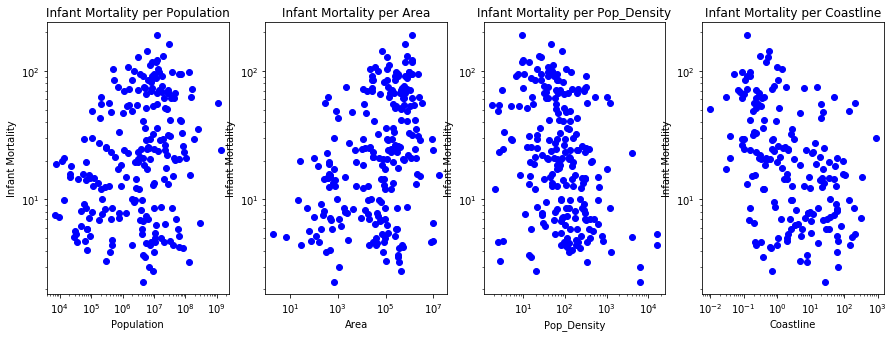

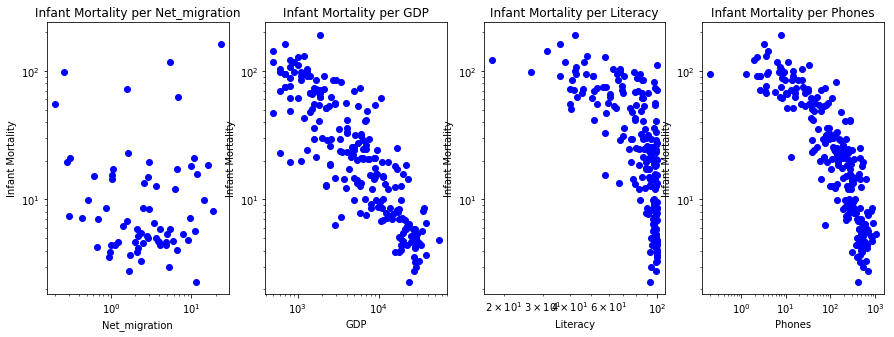

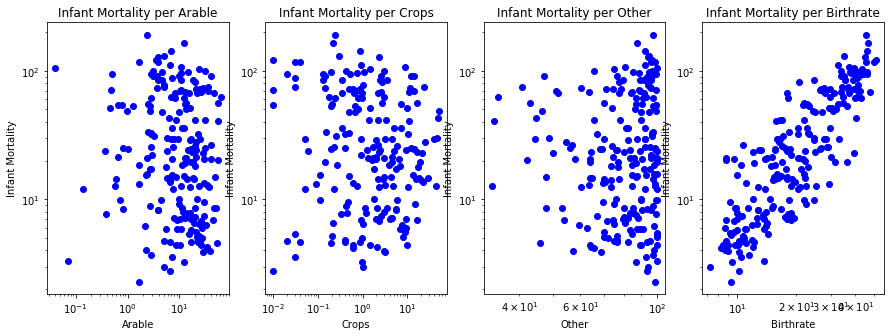

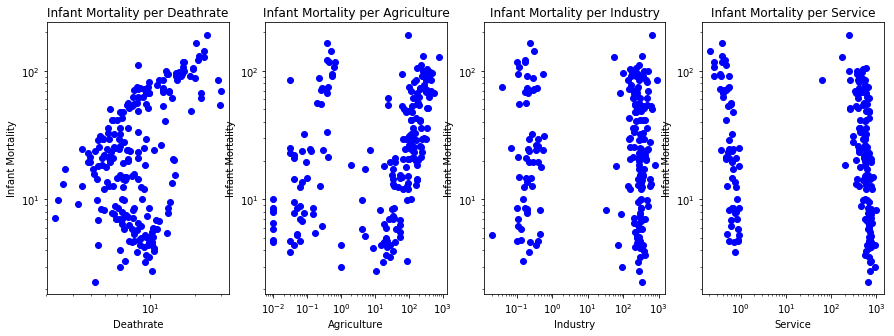

In [14]:
columns = cw.keys().drop(['Code','Infant_mortality','Country', 'Region', 'Climate'])

index = 1
for column in columns:
    
    if index==1: plt.figure(figsize=(15,5))
    
    argument = (cw[column].notnull()) & (cw.Infant_mortality.notnull())

    x = np.array(cw[argument].get(column))
    y = np.array(cw[argument].Infant_mortality)
        
    plt.subplot(140+index)
    plt.loglog(x,y,'bo')
    plt.title('Infant Mortality per {0}'.format(column))
    plt.ylabel('Infant Mortality')
    plt.xlabel('{0}'.format(column))
    
    index+=1
    if index>4:
        index=1
        plt.show()

<h1>Classe para Regressão</h1>

Dado $p$ variáveis independentes $x _ {1},x _ {2},...,x _ {p}$ e uma variável dependente $y$, onde cada 
$x$ e o $y$ representam um vetor com $n$ pontos. Para realizar um ajuste de curva e encontrar a relação entre as variáveis independentes e dependente, construímos o seguinte sistema linear:

$$
\begin{bmatrix}
n & \sum\limits _ { i = 1 } ^ { n } x _ { i 1 } & \sum\limits _ { i = 1 } ^ { n } x _ { i 2 } & \dots & \sum\limits _ { i = 1 } ^ { n } x _ { i p }\\
\sum\limits _ { i = 1 } ^ { n } x _ { i 1 } & \sum\limits _ { i = 1 } ^ { n } x _ { i 1 }x _ { i 1 } & \sum\limits _ { i = 1 } ^ { n } x _ { i 2 }x _ { i 1 } & \dots & \sum\limits _ { i = 1 } ^ { n } x _ { i p }x _ { i 1 }\\
\sum\limits _ { i = 1 } ^ { n } x _ { i 2 } & \sum\limits _ { i = 1 } ^ { n } x _ { i 1 }x _ { i 2 } & \sum\limits _ { i = 1 } ^ { n } x _ { i 2 }x _ { i 2 } & \dots & \sum\limits _ { i = 1 } ^ { n } x _ { i p }x _ { i 2 }\\
\vdots & \vdots & \vdots & \vdots & \vdots \\
\sum\limits _ { i = 1 } ^ { n } x _ { i p } & \sum\limits _ { i = 1 } ^ { n } x _ { i 1 }x _ { i p } & \sum\limits _ { i = 1 } ^ { n } x _ { i 2 }x _ { i p } & \dots & \sum\limits _ { i = 1 } ^ { n } x _ { i p }x _ { i p }\\
\end{bmatrix}
\begin{bmatrix}
b_0\\
b_1\\
b_2\\
\vdots\\
b_p\\
\end{bmatrix}
=
\begin{bmatrix}
\sum\limits _ { i = 1 } ^ { n } y _ { i 1 }\\
\sum\limits _ { i = 1 } ^ { n } y_i x _ { i 1 }\\
\sum\limits _ { i = 1 } ^ { n } y_i x _ { i 2 }\\
\vdots\\
\sum\limits _ { i = 1 } ^ { n } y_i x _ { i p }
\end{bmatrix}
$$

Resolvendo o sistema encontramos os coeficientes da curva e podemos predizer os valores de $y$.

In [15]:
class Regression(object):
    def __init__(self,nDim=2):
        self.nDim=nDim
        
    def train(self,x,y):
        self.x = x
        if x.ndim == 1:
            x = np.asarray([x])
        x = np.array([xi**i for i in range(1,self.nDim) for xi in x])

        n = len(x[0])
        p = len(x)+1

        X = np.zeros((p,p))
        Y = np.zeros(p)

        X[0][0] = n
        Y[0] = y.sum()

        for i in range(1,p):
            Y[i] = (y*x[i-1]).sum()
            X[0][i] = X[i][0] = x[i-1].sum()
            for j in range(1,p):
                X[i][j] = X[j][i] = (x[i-1]*x[j-1]).sum()
        b = cho_solve(cho_factor(X),Y)

        self.b = b

        predict = self.predict(self.x)

        D = y-predict
        D = (D*D).sum()
        self.R2 = 1-(D/((y*y).sum() - ((y.sum())**2 )/n))


    def predict(self,x):
        if x.ndim == 1:
            x = np.asarray([x])
        x = np.array([xi**i for i in range(1,self.nDim) for xi in x])
        x = np.matrix(np.append(np.ones((1,len(x[0]))), x, axis=0))
        return np.array(self.b*x)[0]
        

<h1>Regressão Testes</h1>

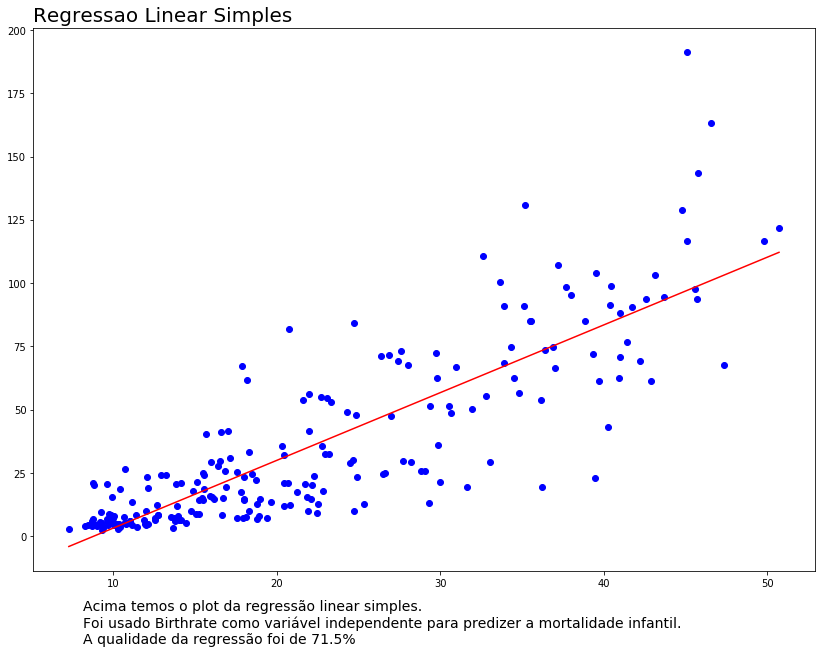

In [21]:
column = 'Birthrate'
argument =  (cw[column].notnull()) & (cw.Infant_mortality.notnull() )

x = np.array(cw[argument].get(column))
y = np.array(cw[argument].Infant_mortality)

lr = Regression(nDim=2)
lr.train(x,y)
x_test = np.linspace(x.min(),x.max(),1000)
predict = lr.predict(x_test)

title = 'Regressao Linear Simples'
description = '''Acima temos o plot da regressão linear simples.
Foi usado {0} como variável independente para predizer a mortalidade infantil.
A qualidade da regressão foi de {1}%'''.strip()
description = description.format(column, round(lr.R2*100,1))

plt.figure(figsize=(14,10))
plt.plot(x,y,'bo')
plt.plot(x_test,predict,'r-')
plt.title(title, fontdict={'fontsize': 20}, loc='left')
plt.annotate(description, xy=(0.1,0.02), size=14, xycoords='figure fraction')
plt.show()

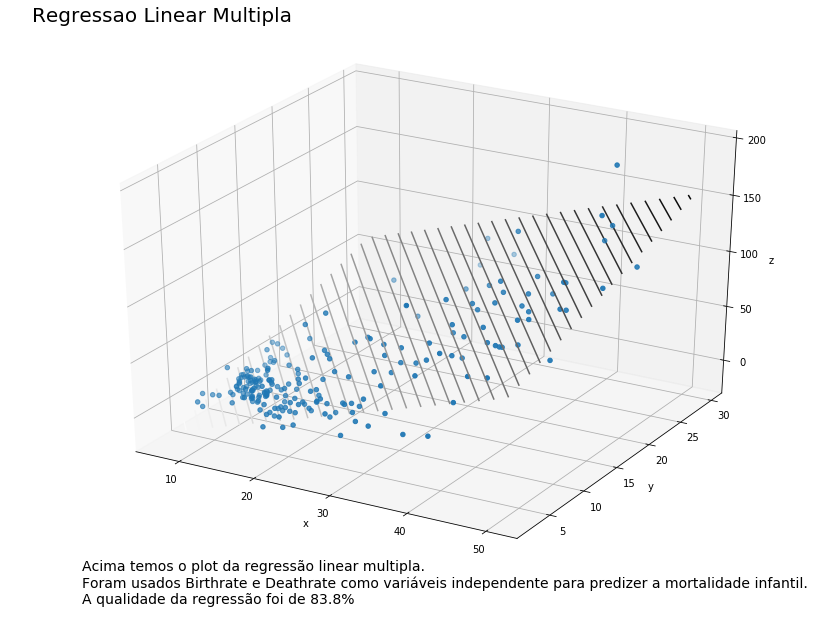

In [29]:
cols = ['Birthrate','Deathrate','Infant_mortality']
argLis = [cw[c].notnull() for c in cols]

for i in range(1,len(argLis)):
    argLis[0] = argLis[0]*argLis[i]
argument = argLis[0]

vi = np.array([cw[argument].get(c) for c in cols[:-1]])
vd = np.array(cw[argument].get(cols[-1]) )

lr = Regression(nDim=2)
lr.train(vi,vd)

x,y=vi
z = vd

X, Y = np.meshgrid(np.linspace(x.min(),x.max(),1000), np.linspace(y.min(),y.max(),1000))
Z = [lr.predict(np.array([X[i],Y[i]])) for i in range(len(X))]


title = 'Regressao Linear Multipla'
description = '''Acima temos o plot da regressão linear multipla.
Foram usados {0} e {1} como variáveis independente para predizer a mortalidade infantil.
A qualidade da regressão foi de {2}%'''.strip()
description = description.format(cols[0],cols[1], round(lr.R2*100,1))

plt.figure(figsize=(14,10))
ax = plt.axes(projection='3d')
ax.scatter(x,y,z)
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(title, fontdict={'fontsize': 20}, loc='left')
ax.annotate(description, xy=(0.1,0.05), size=14, xycoords='figure fraction')
plt.show()


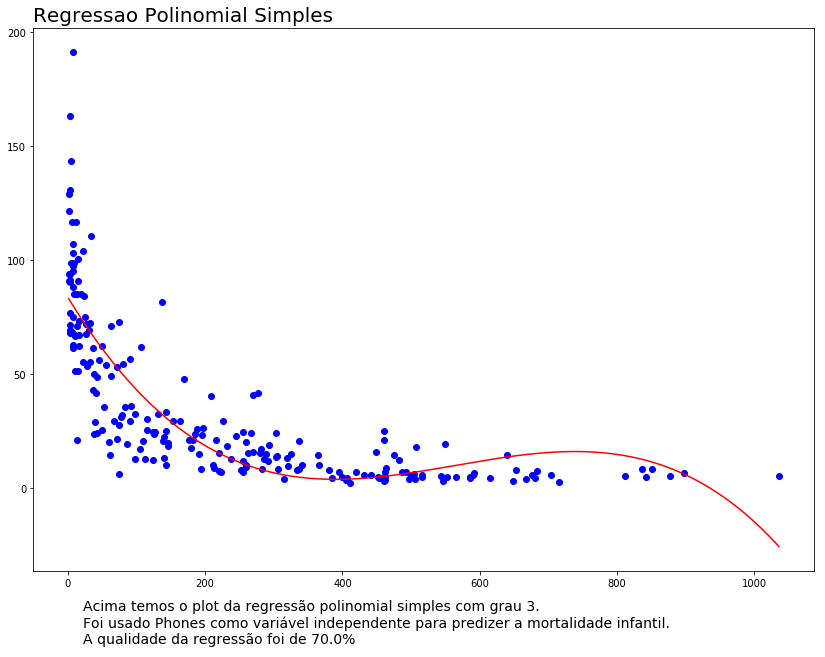

In [40]:
column = 'Phones'
argument =  (cw[column] > 1) & (cw[column].notnull()) & (cw.Infant_mortality.notnull() )

x = np.array(cw[argument].get(column))
y = np.array(cw[argument].Infant_mortality)

lr = Regression(nDim=4)
lr.train(x,y)
x_test = np.linspace(x.min(),x.max(),1000)
predict = lr.predict(x_test)

title = 'Regressao Polinomial Simples'
description = '''Acima temos o plot da regressão polinomial simples com grau {2}.
Foi usado {0} como variável independente para predizer a mortalidade infantil.
A qualidade da regressão foi de {1}%'''.strip()
description = description.format(column, round(lr.R2*100,1), lr.nDim-1)

plt.figure(figsize=(14,10))
plt.plot(x,y,'bo')
plt.plot(x_test,predict,'r-')
plt.title(title, fontdict={'fontsize': 20}, loc='left')
plt.annotate(description, xy=(0.1,0.02), size=14, xycoords='figure fraction')
plt.show()

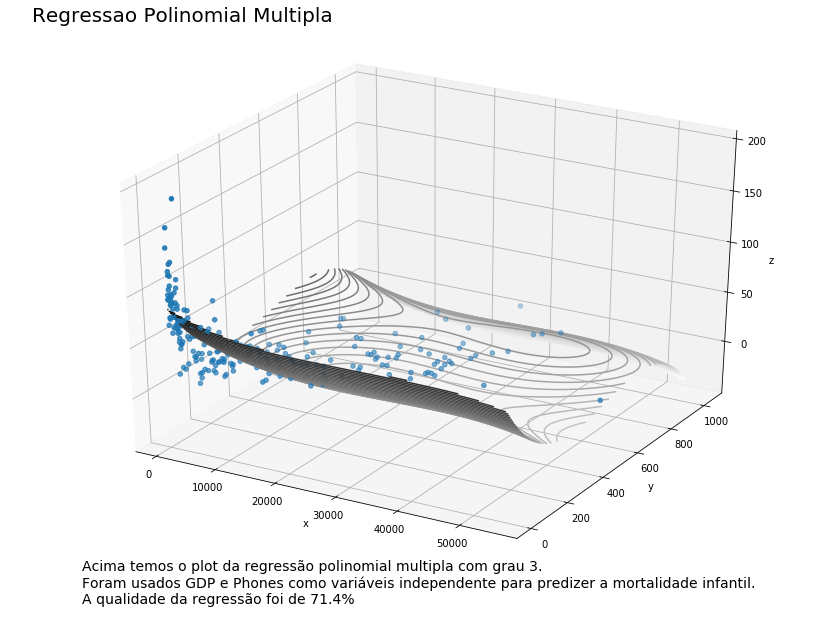

In [9]:
cols = ['GDP','Phones','Infant_mortality']
argLis = [cw[c].notnull() for c in cols]
for i in range(1,len(argLis)):
    argLis[0] = argLis[0]*argLis[i]
argument = argLis[0]

vi = np.array([cw[argument].get(c) for c in cols[:-1]])
vd = np.array(cw[argument].get(cols[-1]) )

lr = Regression(nDim=4)
lr.train(vi,vd)

x,y=vi
z = vd

X, Y = np.meshgrid(np.linspace(x.min(),x.max(),1000), np.linspace(y.min(),y.max(),1000))
Z = [lr.predict(np.array([X[i],Y[i]])) for i in range(len(X))]

title = 'Regressao Polinomial Multipla'
description = '''Acima temos o plot da regressão polinomial multipla com grau {3}.
Foram usados {0} e {1} como variáveis independente para predizer a mortalidade infantil.
A qualidade da regressão foi de {2}%'''.strip()
description = description.format(cols[0],cols[1], round(lr.R2*100,1), lr.nDim-1)

plt.figure(figsize=(14,10))
ax = plt.axes(projection='3d')
ax.scatter(x,y,z)
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(title, fontdict={'fontsize': 20}, loc='left')
ax.annotate(description, xy=(0.1,0.05), size=14, xycoords='figure fraction')
plt.show()